## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

### 根據 resnet_builder.py 撰寫

In [35]:
import tensorflow as tf
import numpy as np
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

#config = tf.ConfigProto()

#config.gpu_options.per_process_gpu_memory_fraction = 1
#sess = tf.Session(config=config)

In [44]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

batch_size = 128  
epochs = 10
data_augmentation = True
num_classes = 10
n = 6
depth = 6 * n + 2

subtract_pixel_mean = True
version = 1

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean 
    x_test -= x_train_mean 

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [45]:
# 對 label 做 one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 學習率動態調整
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [46]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth = depth, num_classes=10):
   
    #if (depth - 2) % 6 != 0:
    #    raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    
    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs=inputs)
    
    for stack in range(3):
        
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  
                strides = 2  
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0: 
                
                
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y]) 
            x = Activation('relu')(x)
        num_filters *= 2

    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [47]:
# 建立 ResNet v1 模型
model = resnet_v1(input_shape=input_shape, depth= depth)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 32, 32, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_114 (BatchN (None, 32, 32, 16)   64          conv2d_124[0][0]                 
__________________________________________________________________________________________________
activation_114 (Activation)     (None, 32, 32, 16)   0           batch_normalization_114[0][0]    
______________________________________________________________________

In [48]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]
print('Using real-time data augmentation.')

Using real-time data augmentation.


In [30]:
# 第一種設定
datagen = ImageDataGenerator(    
    featurewise_center=False,    
    samplewise_center=False,    
    featurewise_std_normalization=False,    
    samplewise_std_normalization=False,    
    zca_whitening=False,    
    zca_epsilon=1e-06,    
    rotation_range=0,    
    width_shift_range=0.1,    
    height_shift_range=0.1,    
    shear_range=0.,    
    zoom_range=0.,    
    channel_shift_range=0.,    
    fill_mode='nearest',    
    cval=0.,    
    horizontal_flip=True,    
    vertical_flip=False,    
    rescale=None,    
    preprocessing_function=None,    
    data_format=None,    
    validation_split=0.0)

datagen.fit(x_train)

In [49]:
# 第二種設定
augment_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [50]:
history = model.fit_generator(augment_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size),
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    workers=4,
                    callbacks=callbacks)

scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/10
Learning rate:  0.001
390/390 [==============================] - 978s 3s/step - loss: 0.4599 - accuracy: 0.9134 - val_loss: 0.4153 - val_accuracy: 0.9122
Epoch 2/10
Learning rate:  0.001
390/390 [==============================] - 989s 3s/step - loss: 0.3281 - accuracy: 0.9307 - val_loss: 0.3844 - val_accuracy: 0.9100
Epoch 3/10
Learning rate:  0.001
390/390 [==============================] - 998s 3s/step - loss: 0.2661 - accuracy: 0.9399 - val_loss: 0.3569 - val_accuracy: 0.9084
Epoch 4/10
Learning rate:  0.001
390/390 [==============================] - 1020s 3s/step - loss: 0.2281 - accuracy: 0.9464 - val_loss: 0.3201 - val_accuracy: 0.9190
Epoch 5/10
Learning rate:  0.001
390/390 [==============================] - 1058s 3s/step - loss: 0.2035 - accuracy: 0.9514 - val_loss: 0.2297 - val_accuracy: 0.9393
Epoch 6/10
Learning rate:  0.001
390/390 [==============================] - 1052s 3s/step - loss: 0.1875 - accuracy: 0.9544 - val_loss: 0.2216 - val_accuracy: 0.9415
Epoch 7

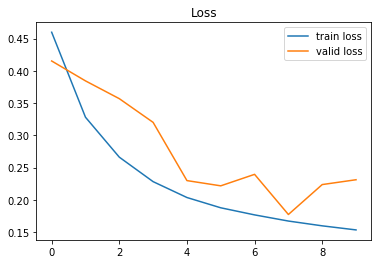

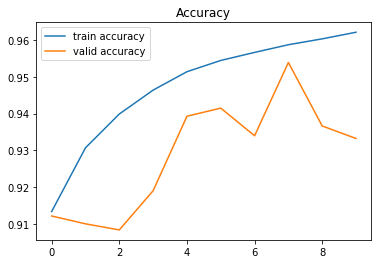

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()